# 2024 CITS4012 Project

**Group 38**


Liweiwen Zhou 24100792
Zirui Xiong 24140167

The Project has been uploaded to Github, for test running please refer to:
https://github.com/WilliamZLee/Enhancing-Aspect-Based-Sentiment-Analysis-with-LSTM-Models

# **Environment set, package import**

In [ ]:
! /opt/bin/nvidia-smi

Sun May 19 18:50:17 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P0              44W / 400W |      2MiB / 40960MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
%cd /content/drive/MyDrive/Colab Notebooks
!ls

/content/drive/MyDrive/Colab Notebooks
 “CITS4012_Lab01.ipynb”的副本	     “CITS4012_Lab07.ipynb”的副本   test.json
'“CITS4012_Lab01.ipynb”的副本 (1)'   “CITS4012_Lab08.ipynb”的副本   train.json
 “CITS4012_Lab02.ipynb”的副本	     “CITS4012_Lab09.ipynb”的副本   Untitled0.ipynb
 “CITS4012_Lab03.ipynb”的副本	     “CITS4012_Lab10.ipynb”的副本   Untitled1.ipynb
 “CITS4012_Lab04.ipynb”的副本	     cuhk_sysu.zip		    Untitled2.ipynb
 “CITS4012_Lab05.ipynb”的副本	     exp_cuhk.zip		    val.json
 “CITS4012_Lab06.ipynb”的副本	     exp_prw.zip


In [ ]:
!pip install nltk
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
!pip install ipywidgets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 33.2 MB/s eta 0:00:00


In [ ]:
!pip install gensim

In [ ]:
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from nltk.tokenize import word_tokenize
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
import os
import gensim.downloader as api
from sklearn.model_selection import ParameterGrid
from sklearn.model_selection import GridSearchCV
from sklearn.base import BaseEstimator, ClassifierMixin

In [ ]:
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display
import torch
from nltk.tokenize import word_tokenize

In [ ]:
import ipywidgets as widgets

In [ ]:
model_dir = os.path.expanduser("~/.cache/gensim/word2vec-google-news-300")


if os.path.exists(model_dir):
    print("Word2Vec is downloaded to local env")
else:
    print("Word2Vec is not downloaded to local env, downloading...")
    word2vec_model = api.load('word2vec-google-news-300')
    print("download complete")


word2vec_model = api.load('word2vec-google-news-300')
print("Word2Vec model successfuly loaded")


print(f"model contains {len(word2vec_model.key_to_index)} words")

Word2Vec is not downloaded to local env, downloading...
[==================================================] 100.0% 1662.8/1662.8MB downloaded
download complete
Word2Vec model successfuly loaded
model contains 3000000 words


# **1.Dataset Processing**

In [ ]:
# Load data
def load_data(file_path):
    data = pd.read_json(file_path, lines=True)
    data = pd.DataFrame(data['data'][0], columns=data['columns'][0])
    return data

# Build vocabulary and index mappings
def build_vocab_and_mappings(data):
    all_reviews = data['sentence'].tolist()
    all_tokens = [token for review in all_reviews for token in word_tokenize(review)]
    vocab = list(set(all_tokens))
    word_to_idx = {word: idx for idx, word in enumerate(vocab)}
    aspect_to_idx = {aspect: idx for idx, aspect in enumerate(set(data['aspect'].tolist()))}
    sentiment_to_idx = {'positive': 0, 'negative': 1, 'neutral': 2}
    return vocab, word_to_idx, aspect_to_idx, sentiment_to_idx


In [ ]:

# Load Word2Vec embeddings
def load_word2vec_embeddings(word2vec_model, word_to_idx, embedding_dim=300):
    embeddings_index = {}
    for word in word2vec_model.key_to_index:
        embeddings_index[word] = word2vec_model[word]

    embedding_matrix = np.zeros((len(word_to_idx), embedding_dim))
    for word, idx in word_to_idx.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[idx] = embedding_vector
    return embedding_matrix

In [ ]:
# Load GloVe embeddings
def load_glove_embeddings(glove_file_path, word_to_idx, embedding_dim=300):
    embeddings_index = {}
    with open(glove_file_path, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs

    embedding_matrix = np.zeros((len(word_to_idx), embedding_dim))
    for word, idx in word_to_idx.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[idx] = embedding_vector
    return embedding_matrix


In [ ]:
# Data preprocessing
def preprocess_data(df, word_to_idx, aspect_to_idx, sentiment_to_idx):
    reviews = [torch.tensor([word_to_idx.get(token, 0) for token in word_tokenize(review)], dtype=torch.long) for review in df['sentence']]
    aspects = torch.tensor([aspect_to_idx[aspect] for aspect in df['aspect']], dtype=torch.long)
    sentiments = torch.tensor([sentiment_to_idx[sentiment] for sentiment in df['polarity']], dtype=torch.long)
    return reviews, aspects, sentiments

# ABSA Dataset
class ABSA_Dataset(Dataset):
    def __init__(self, reviews, aspects, sentiments):
        self.reviews = reviews
        self.aspects = aspects
        self.sentiments = sentiments

    def __len__(self):
        return len(self.reviews)

    def __getitem__(self, idx):
        return self.reviews[idx], self.aspects[idx], self.sentiments[idx]

# Collate function
def collate_fn(batch):
    reviews, aspects, sentiments = zip(*batch)
    reviews_padded = torch.nn.utils.rnn.pad_sequence(reviews, batch_first=True, padding_value=0)
    aspects = torch.tensor(aspects)
    sentiments = torch.tensor(sentiments)
    return reviews_padded, aspects, sentiments

## **Basic LSTM, with Glove and advanced**

In [ ]:
# LSTM BASIC
class BasicLSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, aspect_dim, dropout=0.5,embedding_matrix = None):
        super(BasicLSTM, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.aspect_embedding = nn.Embedding(len(aspect_to_idx), aspect_dim)
        self.lstm = nn.LSTM(embedding_dim + aspect_dim, hidden_dim, batch_first=True, bidirectional=True)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)

    def forward(self, reviews, aspects):
        embedded_reviews = self.embedding(reviews)
        embedded_aspects = self.aspect_embedding(aspects).unsqueeze(1).repeat(1, embedded_reviews.size(1), 1)
        lstm_input = torch.cat((embedded_reviews, embedded_aspects), dim=2)
        lstm_output, _ = self.lstm(lstm_input)
        final_feature_map = self.dropout(lstm_output[:, -1, :])
        output = self.fc(final_feature_map)
        return output

In [ ]:
# LSTM WITH GloVe only
class GloVeLSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, aspect_dim, dropout=0.5, embedding_matrix=None):
        super(GloVeLSTM, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        if embedding_matrix is not None:
            self.embedding.weight.data.copy_(torch.from_numpy(embedding_matrix))
            self.embedding.weight.requires_grad = False
        self.aspect_embedding = nn.Embedding(len(aspect_to_idx), aspect_dim)
        self.lstm = nn.LSTM(embedding_dim + aspect_dim, hidden_dim, batch_first=True, bidirectional=True)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)

    def forward(self, reviews, aspects):
        embedded_reviews = self.embedding(reviews)
        embedded_aspects = self.aspect_embedding(aspects).unsqueeze(1).repeat(1, embedded_reviews.size(1), 1)
        lstm_input = torch.cat((embedded_reviews, embedded_aspects), dim=2)
        lstm_output, _ = self.lstm(lstm_input)
        final_feature_map = self.dropout(lstm_output[:, -1, :])
        output = self.fc(final_feature_map)
        return output


In [ ]:
# LSTM with GloVe and advanced optimize
class AdvancedGloVeLSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, aspect_dim, dropout=0.5, embedding_matrix=True):
        super(AdvancedGloVeLSTM, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        if embedding_matrix is not None:
            self.embedding.weight.data.copy_(torch.from_numpy(embedding_matrix))
            self.embedding.weight.requires_grad = True  # Allow training embeddings
        self.aspect_embedding = nn.Embedding(len(aspect_to_idx), aspect_dim)
        self.lstm = nn.LSTM(embedding_dim + aspect_dim, hidden_dim, batch_first=True, bidirectional=True)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)

    def forward(self, reviews, aspects):
        embedded_reviews = self.embedding(reviews)
        embedded_aspects = self.aspect_embedding(aspects).unsqueeze(1).repeat(1, embedded_reviews.size(1), 1)
        lstm_input = torch.cat((embedded_reviews, embedded_aspects), dim=2)
        lstm_output, _ = self.lstm(lstm_input)
        final_feature_map = self.dropout(lstm_output[:, -1, :])
        output = self.fc(final_feature_map)
        return output


In [ ]:
# Training function with early stopping, learning rate scheduler, and gradient clipping
def train_model(model, train_loader, val_loader, epochs, learning_rate, patience, weight_decay, clip_value):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2, factor=0.5, verbose=True)
    best_val_loss = float('inf')
    patience_counter = 0

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for reviews, aspects, sentiments in train_loader:
            optimizer.zero_grad()
            outputs = model(reviews, aspects)
            loss = criterion(outputs, sentiments)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), clip_value)
            optimizer.step()
            total_loss += loss.item()

        # Evaluate on validation set
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for reviews, aspects, sentiments in val_loader:
                outputs = model(reviews, aspects)
                loss = criterion(outputs, sentiments)
                val_loss += loss.item()

        val_loss /= len(val_loader)
        scheduler.step(val_loss)
        print(f'Epoch {epoch+1}, Training Loss: {total_loss / len(train_loader)}, Validation Loss: {val_loss}')

        # Early stopping logic
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping triggered")
                break

In [ ]:
if __name__ == "__main__":
    # Load and preprocess data
    train_data = load_data('train.json')
    val_data = load_data('val.json')
    test_data = load_data('test.json')

    vocab, word_to_idx, aspect_to_idx, sentiment_to_idx = build_vocab_and_mappings(pd.concat([train_data, val_data, test_data]))

    train_reviews, train_aspects, train_sentiments = preprocess_data(train_data, word_to_idx, aspect_to_idx, sentiment_to_idx)
    val_reviews, val_aspects, val_sentiments = preprocess_data(val_data, word_to_idx, aspect_to_idx, sentiment_to_idx)
    test_reviews, test_aspects, test_sentiments = preprocess_data(test_data, word_to_idx, aspect_to_idx, sentiment_to_idx)

    # Load GloVe embeddings
    embedding_matrix = load_glove_embeddings('glove.6B.300d.txt', word_to_idx) if use_glove else None

    # Initialize datasets and data loaders
    train_dataset = ABSA_Dataset(train_reviews, train_aspects, train_sentiments)
    val_dataset = ABSA_Dataset(val_reviews, val_aspects, val_sentiments)
    test_dataset = ABSA_Dataset(test_reviews, test_aspects, test_sentiments)

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)

    # Define and train models for each stage
    for stage, ModelClass in zip(["Basic", "GloVe", "AdvancedGloVe"], [BasicLSTM, GloVeLSTM, AdvancedGloVeLSTM]):
        print(f"Training {stage} Model")
        model = ModelClass(len(vocab), 300, 128, 3, len(aspect_to_idx), embedding_matrix=embedding_matrix)
        train_model(model, train_loader, val_loader, epochs=10, learning_rate=0.001, patience=3, weight_decay=1e-5, clip_value=1.0)

        val_accuracy, val_precision, val_recall, val_cm = evaluate_model_performance(model, val_loader)
        print(f'{stage} Model Validation Accuracy: {val_accuracy}')
        print(f'{stage} Model Validation Precision: {val_precision}')
        print(f'{stage} Model Validation Recall: {val_recall}')
        print(f'{stage} Model Validation Confusion Matrix:\n{val_cm}')

        test_accuracy, test_precision, test_recall, test_cm = evaluate_model_performance(model, test_loader)
        print(f'{stage} Model Test Accuracy: {test_accuracy}')
        print(f'{stage} Model Test Precision: {test_precision}')
        print(f'{stage} Model Test Recall: {test_recall}')
        print(f'{stage} Model Test Confusion Matrix:\n{test_cm}')


# **2.Model Implementation**

# **LSTM with GloVe and Grid_Search for optimal parameter set**

In [ ]:
class LSTMModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, aspect_dim, use_attention=False,return_attention = False, dropout=0.5, embedding_matrix=None):
        super(LSTMModel, self).__init__()
        self.use_attention = use_attention
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.return_attention = return_attention
        if embedding_matrix is not None:
            self.embedding.weight.data.copy_(torch.from_numpy(embedding_matrix))
            self.embedding.weight.requires_grad = False
        self.aspect_embedding = nn.Embedding(len(aspect_to_idx), aspect_dim)
        self.lstm = nn.LSTM(embedding_dim + aspect_dim, hidden_dim, batch_first=True, bidirectional=True)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)
        if use_attention:
            self.attention = nn.Linear(hidden_dim * 2 + aspect_dim, 1)

    def forward(self, reviews, aspects):
        embedded_reviews = self.embedding(reviews)
        embedded_aspects = self.aspect_embedding(aspects).unsqueeze(1).repeat(1, embedded_reviews.size(1), 1)
        lstm_input = torch.cat((embedded_reviews, embedded_aspects), dim=2)
        lstm_output, _ = self.lstm(lstm_input)
        if self.use_attention:
            attn_input = torch.cat((lstm_output, embedded_aspects), dim=2)
            attn_weights = F.softmax(self.attention(attn_input), dim=1)
            attn_applied = torch.bmm(attn_weights.transpose(1, 2), lstm_output)
            final_feature_map = self.dropout(attn_applied.squeeze(1))
        else:
            final_feature_map = self.dropout(lstm_output[:, -1, :])

        output = self.fc(final_feature_map)

        if self.use_attention and self.return_attention:
            return output, attn_weights
        return output

In [ ]:
# Modify the train_model function to accept parameters
def train_model(model, train_loader, val_loader, epochs, learning_rate, patience, weight_decay, clip_value):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2, factor=0.5)
    best_val_loss = float('inf')

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for reviews, aspects, sentiments in train_loader:
            optimizer.zero_grad()
            outputs = model(reviews, aspects)
            loss = criterion(outputs, sentiments)
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), clip_value)
            optimizer.step()
            total_loss += loss.item()

        val_loss = evaluate_model(model, val_loader)
        scheduler.step(val_loss)

        if val_loss < best_val_loss:
            best_val_loss = val_loss

In [ ]:
# Using sklearn's GridSearchCV to automate the hyperparameter tuning
def perform_grid_search(train_loader, val_loader, vocab_size, aspect_dim, embedding_matrix):
    param_grid = {
        'hidden_dim': [64, 128],
        'dropout': [0.5, 0.7],
        'learning_rate': [0.001, 0.01],
        'weight_decay': [1e-4, 1e-5]
    }
    best_score = 0
    best_params = None

    for params in ParameterGrid(param_grid):
        model = LSTMModel(vocab_size, 300, params['hidden_dim'], 3, aspect_dim, use_attention=True, dropout=params['dropout'], embedding_matrix=embedding_matrix)
        train_model(model, train_loader, val_loader, 10, params['learning_rate'], 3, params['weight_decay'], 1.0)
        val_accuracy, _, _, _ = evaluate_model_performance(model, val_loader)
        if val_accuracy > best_score:
            best_score = val_accuracy
            best_params = params

    return best_params, best_score



load glove.6B.300d.txt

In [ ]:
cd ..

/content/drive/MyDrive


In [ ]:
cd ..

/content/drive


In [ ]:
cd ..

/content


In [ ]:
!unzip "/content/drive/MyDrive/glove.6B.300d.zip" -d "/content"

Archive:  /content/drive/MyDrive/glove.6B.300d.zip
  inflating: /content/glove.6B.300d.txt  


In [ ]:
if __name__ == "__main__":
    # Load and preprocess data
    train_data = load_data('train.json')
    val_data = load_data('val.json')
    test_data = load_data('test.json')

    vocab, word_to_idx, aspect_to_idx, sentiment_to_idx = build_vocab_and_mappings(pd.concat([train_data, val_data, test_data]))

    train_reviews, train_aspects, train_sentiments = preprocess_data(train_data, word_to_idx, aspect_to_idx, sentiment_to_idx)
    val_reviews, val_aspects, val_sentiments = preprocess_data(val_data, word_to_idx, aspect_to_idx, sentiment_to_idx)
    test_reviews, test_aspects, test_sentiments = preprocess_data(test_data, word_to_idx, aspect_to_idx, sentiment_to_idx)

    # Load GloVe embeddings if desired
    embedding_matrix = load_glove_embeddings('glove.6B.300d.txt', word_to_idx)

    # Initialize datasets and data loaders
    train_dataset = ABSA_Dataset(train_reviews, train_aspects, train_sentiments)
    val_dataset = ABSA_Dataset(val_reviews, val_aspects, val_sentiments)
    test_dataset = ABSA_Dataset(test_reviews, test_aspects, test_sentiments)
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)

    # Perform grid search
    best_params, best_score = perform_grid_search(train_loader, val_loader, len(vocab), len(aspect_to_idx), embedding_matrix)
    print(f"Best Parameters: {best_params}")
    print(f"Best Validation Score: {best_score}")

    # Train final model with best parameters
    final_model_GloVe = LSTMModel(
        len(vocab),
        300,  # Assuming embedding_dim is 300
        best_params['hidden_dim'],
        3,  # Assuming output_dim is 3 (e.g., positive, negative, neutral)
        len(aspect_to_idx),
        use_attention=True,  # Assuming we always use attention
        dropout=best_params['dropout'],
        embedding_matrix=embedding_matrix
    )

    # Train the model
    train_model(final_model_GloVe, train_loader, val_loader, epochs=10,
                learning_rate=best_params['learning_rate'],
                patience=5,  # Adjust according to your setup
                weight_decay=best_params['weight_decay'])

    # Evaluate and save the model
    val_accuracy, val_precision, val_recall, val_cm = evaluate_model_performance(final_model_GloVe, val_loader)
    print(f'Validation Accuracy: {val_accuracy}')
    print(f'Validation Precision: {val_precision}')
    print(f'Validation Recall: {val_recall}')
    print(f'Validation Confusion Matrix:\n{val_cm}')

    # Save the trained model
    torch.save(final_model_GloVe.state_dict(), 'path_to_final_model_GloVe.pth')
    print("Model saved successfully!")

Epoch 1, Training Loss: 1.0988551496385455, Validation Loss: 1.0856695132596152
Epoch 2, Training Loss: 1.0875755859924867, Validation Loss: 1.0754969588347845
Epoch 3, Training Loss: 1.07766602195061, Validation Loss: 1.0667213797569275
Epoch 4, Training Loss: 1.0697467160654497, Validation Loss: 1.0590374725205558
Epoch 5, Training Loss: 1.0624679308216851, Validation Loss: 1.0519102684089117
Epoch 6, Training Loss: 1.0570559039846197, Validation Loss: 1.0453973455088479
Epoch 7, Training Loss: 1.049886636905842, Validation Loss: 1.0391520261764526
Epoch 8, Training Loss: 1.0454610916408333, Validation Loss: 1.0332612948758262
Epoch 9, Training Loss: 1.0397945041055079, Validation Loss: 1.0276082711560386
Epoch 10, Training Loss: 1.0333872316656887, Validation Loss: 1.0220979835305894


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1, Training Loss: 1.0896768467920321, Validation Loss: 1.0799452917916434
Epoch 2, Training Loss: 1.0823657947617609, Validation Loss: 1.073601735489709
Epoch 3, Training Loss: 1.0777501372603682, Validation Loss: 1.068947617496763
Epoch 4, Training Loss: 1.073666311062134, Validation Loss: 1.0652854655470168
Epoch 5, Training Loss: 1.0705420541333723, Validation Loss: 1.0620635151863098
Epoch 6, Training Loss: 1.0684200122549727, Validation Loss: 1.0590717153889793
Epoch 7, Training Loss: 1.0641096661219727, Validation Loss: 1.0562647836548942
Epoch 8, Training Loss: 1.0626626406703983, Validation Loss: 1.0535263887473516
Epoch 9, Training Loss: 1.0599270288471703, Validation Loss: 1.0508714744022913
Epoch 10, Training Loss: 1.0586159538041364, Validation Loss: 1.0481854464326585


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1, Training Loss: 1.0647073976091437, Validation Loss: 1.032025865146092
Epoch 2, Training Loss: 1.0208960280225083, Validation Loss: 0.9954320809670857
Epoch 3, Training Loss: 0.9955533869094677, Validation Loss: 0.9708382487297058
Epoch 4, Training Loss: 0.9781076698689848, Validation Loss: 0.9538076434816632
Epoch 5, Training Loss: 0.9629464944203695, Validation Loss: 0.9403399718659264
Epoch 6, Training Loss: 0.955417370205527, Validation Loss: 0.9318751714059285
Epoch 7, Training Loss: 0.9496807053282454, Validation Loss: 0.9262628363711494
Epoch 8, Training Loss: 0.9441053029653188, Validation Loss: 0.9206281027623585
Epoch 9, Training Loss: 0.9380247163343, Validation Loss: 0.9181205758026668
Epoch 10, Training Loss: 0.9352446354187287, Validation Loss: 0.9140524502311435
Epoch 1, Training Loss: 1.045704449619259, Validation Loss: 0.9968132653406688
Epoch 2, Training Loss: 0.9897146751214793, Validation Loss: 0.9557842995439257
Epoch 3, Training Loss: 0.9665783031566723, V

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1, Training Loss: 1.0797797044118245, Validation Loss: 1.073936104774475
Epoch 2, Training Loss: 1.0692264757177852, Validation Loss: 1.0630508320672172
Epoch 3, Training Loss: 1.0612543802540582, Validation Loss: 1.053733961922782
Epoch 4, Training Loss: 1.0538815380753697, Validation Loss: 1.0452435612678528
Epoch 5, Training Loss: 1.0455437334808144, Validation Loss: 1.0373016425541468
Epoch 6, Training Loss: 1.0397904472308115, Validation Loss: 1.0297047282968248
Epoch 7, Training Loss: 1.032935021696864, Validation Loss: 1.0224569950784956
Epoch 8, Training Loss: 1.0246797332892548, Validation Loss: 1.0153181850910187
Epoch 9, Training Loss: 1.018505035488455, Validation Loss: 1.0084360433476312
Epoch 10, Training Loss: 1.0128745707842681, Validation Loss: 1.0016932785511017


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1, Training Loss: 1.0484592536011257, Validation Loss: 1.0111071999583925
Epoch 2, Training Loss: 0.9942904192585129, Validation Loss: 0.9659185622419629
Epoch 3, Training Loss: 0.9641426514397871, Validation Loss: 0.9418045324938638
Epoch 4, Training Loss: 0.950458637765936, Validation Loss: 0.930301200066294
Epoch 5, Training Loss: 0.9432023398511045, Validation Loss: 0.9235838417496
Epoch 6, Training Loss: 0.9375115412849564, Validation Loss: 0.9173138844115394
Epoch 7, Training Loss: 0.9354893981336473, Validation Loss: 0.9134509457009179
Epoch 8, Training Loss: 0.9325645912337948, Validation Loss: 0.9110856865133558
Epoch 9, Training Loss: 0.9297208034240447, Validation Loss: 0.9082958059651511
Epoch 10, Training Loss: 0.9264369223031912, Validation Loss: 0.9054903898920331


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1, Training Loss: 1.0551415211982555, Validation Loss: 1.02139578972544
Epoch 2, Training Loss: 1.0075302822095853, Validation Loss: 0.9774589261838368
Epoch 3, Training Loss: 0.9745207828981383, Validation Loss: 0.9480061594929013
Epoch 4, Training Loss: 0.9551059697662387, Validation Loss: 0.9312806065593447
Epoch 5, Training Loss: 0.9478453024550602, Validation Loss: 0.9226797286953244
Epoch 6, Training Loss: 0.9415699756360268, Validation Loss: 0.9173632924045835
Epoch 7, Training Loss: 0.9382051632211015, Validation Loss: 0.9131746483700616
Epoch 8, Training Loss: 0.9328537484010061, Validation Loss: 0.9103063515254429
Epoch 9, Training Loss: 0.931975669957496, Validation Loss: 0.9076674090964454
Epoch 10, Training Loss: 0.9296591826924333, Validation Loss: 0.9055243900844029
Epoch 1, Training Loss: 1.1023750417941325, Validation Loss: 1.0927932177271162
Epoch 2, Training Loss: 1.09200335515512, Validation Loss: 1.0860148753438676
Epoch 3, Training Loss: 1.088055094620129, V

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1, Training Loss: 1.1163841743726988, Validation Loss: 1.1030048089368003
Epoch 2, Training Loss: 1.0983900701677478, Validation Loss: 1.088604177747454
Epoch 3, Training Loss: 1.0885321062964362, Validation Loss: 1.0773470912660872
Epoch 4, Training Loss: 1.0785074481019028, Validation Loss: 1.0682763797896249
Epoch 5, Training Loss: 1.0698585566636678, Validation Loss: 1.0602959096431732
Epoch 6, Training Loss: 1.0650041398701366, Validation Loss: 1.0533740988799505
Epoch 7, Training Loss: 1.0567462812135886, Validation Loss: 1.047065304858344
Epoch 8, Training Loss: 1.052214802116961, Validation Loss: 1.0411902942827769
Epoch 9, Training Loss: 1.0465459914894792, Validation Loss: 1.0355515352317266
Epoch 10, Training Loss: 1.0451251587889216, Validation Loss: 1.0303494312933512


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1, Training Loss: 1.037540697031193, Validation Loss: 0.9843074487788337
Epoch 2, Training Loss: 0.9830419158076381, Validation Loss: 0.939133597271783
Epoch 3, Training Loss: 0.954351055997986, Validation Loss: 0.919145154101508
Epoch 4, Training Loss: 0.9471228192518423, Validation Loss: 0.9112492480448314
Epoch 5, Training Loss: 0.9407390348009161, Validation Loss: 0.9070268848112651
Epoch 6, Training Loss: 0.9375436120742077, Validation Loss: 0.9046697531427655
Epoch 7, Training Loss: 0.9298277835588198, Validation Loss: 0.9028164318629673
Epoch 8, Training Loss: 0.934819180954684, Validation Loss: 0.9018261496509824
Epoch 9, Training Loss: 0.9301171547120756, Validation Loss: 0.9009361820561546
Epoch 10, Training Loss: 0.9301081493094161, Validation Loss: 0.9005579948425293
Epoch 1, Training Loss: 1.0575917478617247, Validation Loss: 1.0258926153182983
Epoch 2, Training Loss: 1.019926073851886, Validation Loss: 0.9904054914202008
Epoch 3, Training Loss: 0.9948280593296429, V

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1, Training Loss: 1.0836546539186358, Validation Loss: 1.0696849056652613
Epoch 2, Training Loss: 1.07226336378235, Validation Loss: 1.0592577840600694
Epoch 3, Training Loss: 1.0615722477973044, Validation Loss: 1.0515927970409393
Epoch 4, Training Loss: 1.0601238272748552, Validation Loss: 1.0453332151685442
Epoch 5, Training Loss: 1.0521778837517575, Validation Loss: 1.0394458643027715
Epoch 6, Training Loss: 1.0476131968133084, Validation Loss: 1.0340891927480698
Epoch 7, Training Loss: 1.045302178140159, Validation Loss: 1.029166694198336
Epoch 8, Training Loss: 1.038841247021615, Validation Loss: 1.0244179133858
Epoch 9, Training Loss: 1.0318560858030577, Validation Loss: 1.0197714567184448
Epoch 10, Training Loss: 1.030000951913026, Validation Loss: 1.0153345039912633


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1, Training Loss: 1.0525081563103307, Validation Loss: 1.0105844203914915
Epoch 2, Training Loss: 1.00531487636738, Validation Loss: 0.9784868082829884
Epoch 3, Training Loss: 0.9853973125552272, Validation Loss: 0.963143412555967
Epoch 4, Training Loss: 0.9758130706645347, Validation Loss: 0.954184176666396
Epoch 5, Training Loss: 0.9707176113450849, Validation Loss: 0.9493736071246011
Epoch 6, Training Loss: 0.9673347583225181, Validation Loss: 0.9438191183975765
Epoch 7, Training Loss: 0.9603371614808435, Validation Loss: 0.9390991032123566
Epoch 8, Training Loss: 0.9590330899835707, Validation Loss: 0.9355548598936626
Epoch 9, Training Loss: 0.9541618904551944, Validation Loss: 0.9308208440031324
Epoch 10, Training Loss: 0.9508759948584411, Validation Loss: 0.9264481323105949
Epoch 1, Training Loss: 1.0650535467508677, Validation Loss: 1.0312049452747618
Epoch 2, Training Loss: 1.0204413468773301, Validation Loss: 0.9904837267739433
Epoch 3, Training Loss: 0.9935312649688205,

# **LSTM with Word2Vec and Grid_Search for Hyperparameter**

In [ ]:
# Hyperparameter search
def grid_search(train_loader, val_loader, param_grid):
    param_grid = list(ParameterGrid(param_grid))
    best_params = None
    best_val_accuracy = 0

    for params in param_grid:
        print(f"Training with params: {params}")
        model = LSTMModel(len(vocab), params['embedding_dim'], params['hidden_dim'], 3, len(aspect_to_idx),
                          use_attention=params['use_attention'], dropout=params['dropout'], embedding_matrix=embedding_matrix)
        train_model(model, train_loader, val_loader, epochs=params['epochs'], learning_rate=params['learning_rate'],
                    patience=params['patience'], weight_decay=params['weight_decay'], clip_value=params['clip_value'])

        val_accuracy, val_precision, val_recall, val_cm = evaluate_model_performance(model, val_loader)
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            best_params = params
        print(f"Validation Accuracy: {val_accuracy}")

    print(f"Best params: {best_params}, Best Validation Accuracy: {best_val_accuracy}")
    return best_params

In [ ]:
class LSTMModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, aspect_dim, use_attention=False, return_attention=False, dropout=0.5, embedding_matrix=None):
        super(LSTMModel, self).__init__()
        self.use_attention = use_attention
        self.return_attention = return_attention  # control the return of attention value
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        if embedding_matrix is not None:
            self.embedding.weight.data.copy_(torch.from_numpy(embedding_matrix))
            self.embedding.weight.requires_grad = False  # Optionally freeze embeddings
        self.aspect_embedding = nn.Embedding(len(aspect_to_idx), aspect_dim)
        self.lstm = nn.LSTM(embedding_dim + aspect_dim, hidden_dim, batch_first=True, bidirectional=True)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)
        if use_attention:
            self.attention = nn.Linear(hidden_dim * 2 + aspect_dim, 1)

    def forward(self, reviews, aspects):
        embedded_reviews = self.embedding(reviews)
        embedded_aspects = self.aspect_embedding(aspects).unsqueeze(1).repeat(1, embedded_reviews.size(1), 1)
        lstm_input = torch.cat((embedded_reviews, embedded_aspects), dim=2)
        lstm_output, _ = self.lstm(lstm_input)

        if self.use_attention:
            attn_input = torch.cat((lstm_output, embedded_aspects), dim=2)
            attn_scores = self.attention(attn_input)
            attn_weights = F.softmax(attn_scores, dim=1)
            attn_applied = torch.bmm(attn_weights.transpose(1, 2), lstm_output)
            final_feature_map = self.dropout(attn_applied.squeeze(1))
        else:
            final_feature_map = self.dropout(lstm_output[:, -1, :])

        output = self.fc(final_feature_map)

        if self.use_attention and self.return_attention:
            return output, attn_weights
        return output



In [ ]:
# Training function with early stopping, learning rate scheduler, and gradient clipping
def train_model(model, train_loader, val_loader, epochs, learning_rate, patience=3, weight_decay=0.0, clip_value=1.0):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2, factor=0.5)
    best_val_loss = float('inf')
    patience_counter = 0

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for reviews, aspects, sentiments in train_loader:
            optimizer.zero_grad()
            outputs = model(reviews, aspects)
            loss = criterion(outputs, sentiments)
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), clip_value)
            optimizer.step()
            total_loss += loss.item()

        val_loss = evaluate_model(model, val_loader)
        scheduler.step(val_loss)
        print(f'Epoch {epoch+1}, Training Loss: {total_loss/len(train_loader)}, Validation Loss: {val_loss/len(val_loader)}')

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print("Early stopping triggered")
            break

In [ ]:

# Evaluation function
def evaluate_model(model, val_loader):
    model.eval()
    total_loss = 0
    criterion = nn.CrossEntropyLoss()
    with torch.no_grad():
        for reviews, aspects, sentiments in val_loader:
            outputs = model(reviews, aspects)
            loss = criterion(outputs, sentiments)
            total_loss += loss.item()
    return total_loss

# Evaluate model performance
def evaluate_model_performance(model, data_loader):
    model.eval()
    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for reviews, aspects, sentiments in data_loader:
            outputs = model(reviews, aspects)
            _, predictions = torch.max(outputs, 1)
            all_predictions.extend(predictions.cpu().numpy())
            all_labels.extend(sentiments.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_predictions)
    precision = precision_score(all_labels, all_predictions, average='weighted')
    recall = recall_score(all_labels, all_predictions, average='weighted')
    cm = confusion_matrix(all_labels, all_predictions)

    return accuracy, precision, recall, cm

In [ ]:
# Main execution block
if __name__ == "__main__":
    # Load and preprocess data
    train_data = load_data('train.json')
    val_data = load_data('val.json')
    test_data = load_data('test.json')

    vocab, word_to_idx, aspect_to_idx, sentiment_to_idx = build_vocab_and_mappings(pd.concat([train_data, val_data, test_data]))

    train_reviews, train_aspects, train_sentiments = preprocess_data(train_data, word_to_idx, aspect_to_idx, sentiment_to_idx)
    val_reviews, val_aspects, val_sentiments = preprocess_data(val_data, word_to_idx, aspect_to_idx, sentiment_to_idx)
    test_reviews, test_aspects, test_sentiments = preprocess_data(test_data, word_to_idx, aspect_to_idx, sentiment_to_idx)

    # Load Word2Vec embeddings
    word2vec_model = api.load('word2vec-google-news-300')
    embedding_matrix = load_word2vec_embeddings(word2vec_model, word_to_idx)

    # Initialize datasets and data loaders
    train_dataset = ABSA_Dataset(train_reviews, train_aspects, train_sentiments)
    val_dataset = ABSA_Dataset(val_reviews, val_aspects, val_sentiments)
    test_dataset = ABSA_Dataset(test_reviews, test_aspects, test_sentiments)

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)

    # Hyperparameter grid search
    param_grid = {
        'embedding_dim': [300],
        'hidden_dim': [64],
        'use_attention': [True],
        'dropout': [0.5],
        'epochs': [10,20],
        'learning_rate': [0.001, 0.01],
        'patience': [3,5],
        'weight_decay': [1e-4, 1e-5],
        'clip_value': [1.0]
    }
    best_params = grid_search(train_loader, val_loader, param_grid)

    # Train final model with best parameters
    final_model = LSTMModel(len(vocab), best_params['embedding_dim'], best_params['hidden_dim'], 3, len(aspect_to_idx),
                            use_attention=best_params['use_attention'], dropout=best_params['dropout'], embedding_matrix=embedding_matrix)
    train_model(final_model, train_loader, val_loader, epochs=best_params['epochs'], learning_rate=best_params['learning_rate'],
                patience=best_params['patience'], weight_decay=best_params['weight_decay'], clip_value=best_params['clip_value'])

    # Evaluate final model performance
    val_accuracy, val_precision, val_recall, val_cm = evaluate_model_performance(final_model, val_loader)
    print(f'Final Validation Accuracy: {val_accuracy}')
    print(f'Final Validation Precision: {val_precision}')
    print(f'Final Validation Recall: {val_recall}')
    print(f'Final Validation Confusion Matrix:\n{val_cm}')

    test_accuracy, test_precision, test_recall, test_cm = evaluate_model_performance(final_model, test_loader)
    print(f'Final Test Accuracy: {test_accuracy}')
    print(f'Final Test Precision: {test_precision}')
    print(f'Final Test Recall: {test_recall}')
    print(f'Final Test Confusion Matrix:\n{test_cm}')

Training with params: {'clip_value': 1.0, 'dropout': 0.5, 'embedding_dim': 300, 'epochs': 10, 'hidden_dim': 64, 'learning_rate': 0.001, 'patience': 3, 'use_attention': True, 'weight_decay': 0.0001}
Epoch 1, Training Loss: 1.1095963082871996, Validation Loss: 1.0961687053952898
Epoch 2, Training Loss: 1.0866952758651596, Validation Loss: 1.073012215750558
Epoch 3, Training Loss: 1.0688678896104968, Validation Loss: 1.0549434678895133
Epoch 4, Training Loss: 1.0553732557339712, Validation Loss: 1.0405311371598924
Epoch 5, Training Loss: 1.0442651819001447, Validation Loss: 1.0287043069090163
Epoch 6, Training Loss: 1.035262378486427, Validation Loss: 1.018949908869607
Epoch 7, Training Loss: 1.030064933740341, Validation Loss: 1.010693290403911
Epoch 8, Training Loss: 1.0230323511200983, Validation Loss: 1.003521284886769
Epoch 9, Training Loss: 1.0183171240596083, Validation Loss: 0.9973858169146946
Epoch 10, Training Loss: 1.0128358860273619, Validation Loss: 0.9919011784451348
Validat

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1, Training Loss: 1.1005733115179044, Validation Loss: 1.094179323741368
Epoch 2, Training Loss: 1.08934532629477, Validation Loss: 1.0825557197843279
Epoch 3, Training Loss: 1.0781954575229336, Validation Loss: 1.0721919238567352
Epoch 4, Training Loss: 1.0693752040734161, Validation Loss: 1.0627621582576208
Epoch 5, Training Loss: 1.060126171455727, Validation Loss: 1.054270327091217
Epoch 6, Training Loss: 1.0517455156858977, Validation Loss: 1.0464836699622018
Epoch 7, Training Loss: 1.0451275706291199, Validation Loss: 1.0393622176987785
Epoch 8, Training Loss: 1.038597464292973, Validation Loss: 1.0326496213674545
Epoch 9, Training Loss: 1.031849750258901, Validation Loss: 1.0264195586953844
Epoch 10, Training Loss: 1.026629797778688, Validation Loss: 1.0206963952098573
Validation Accuracy: 0.5574324324324325
Training with params: {'clip_value': 1.0, 'dropout': 0.5, 'embedding_dim': 300, 'epochs': 10, 'hidden_dim': 64, 'learning_rate': 0.001, 'patience': 5, 'use_attention':

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1, Training Loss: 1.0917765256520864, Validation Loss: 1.0854348497731345
Epoch 2, Training Loss: 1.0819518141918354, Validation Loss: 1.0752782608781541
Epoch 3, Training Loss: 1.0735213037009712, Validation Loss: 1.066443805183683
Epoch 4, Training Loss: 1.06587612091958, Validation Loss: 1.0586635512965066
Epoch 5, Training Loss: 1.0590232143530975, Validation Loss: 1.0517368699823106
Epoch 6, Training Loss: 1.053687713973157, Validation Loss: 1.045489149434226
Epoch 7, Training Loss: 1.048488445647128, Validation Loss: 1.0398130927767073
Epoch 8, Training Loss: 1.042325487007966, Validation Loss: 1.0346107546772276
Epoch 9, Training Loss: 1.0376681728405996, Validation Loss: 1.0297688565083913
Epoch 10, Training Loss: 1.0338830351829529, Validation Loss: 1.0252892289842879
Validation Accuracy: 0.5574324324324325
Training with params: {'clip_value': 1.0, 'dropout': 0.5, 'embedding_dim': 300, 'epochs': 10, 'hidden_dim': 64, 'learning_rate': 0.001, 'patience': 5, 'use_attention'

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1, Training Loss: 1.1003850091685046, Validation Loss: 1.092415064573288
Epoch 2, Training Loss: 1.0875405518858283, Validation Loss: 1.0798982211521693
Epoch 3, Training Loss: 1.0765895440771773, Validation Loss: 1.0691064085279192
Epoch 4, Training Loss: 1.0661687665694468, Validation Loss: 1.0596302364553725
Epoch 5, Training Loss: 1.0577866354504146, Validation Loss: 1.0512336535113198
Epoch 6, Training Loss: 1.049751084398579, Validation Loss: 1.0436590484210424
Epoch 7, Training Loss: 1.043484892662581, Validation Loss: 1.0367235562631063
Epoch 8, Training Loss: 1.0382711484625533, Validation Loss: 1.0302864100251878
Epoch 9, Training Loss: 1.0328547393416498, Validation Loss: 1.024380624294281
Epoch 10, Training Loss: 1.0261390751546569, Validation Loss: 1.0187536073582513
Validation Accuracy: 0.5574324324324325
Training with params: {'clip_value': 1.0, 'dropout': 0.5, 'embedding_dim': 300, 'epochs': 10, 'hidden_dim': 64, 'learning_rate': 0.01, 'patience': 3, 'use_attentio

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1, Training Loss: 1.0487424634598397, Validation Loss: 1.0101623428719384
Epoch 2, Training Loss: 0.9951091435578492, Validation Loss: 0.9655696941273553
Epoch 3, Training Loss: 0.9643510185383461, Validation Loss: 0.9412297031709126
Epoch 4, Training Loss: 0.9507141744231319, Validation Loss: 0.9295915194920131
Epoch 5, Training Loss: 0.9415134803668873, Validation Loss: 0.9238048046827316
Epoch 6, Training Loss: 0.9386082125139666, Validation Loss: 0.9199306475264686
Epoch 7, Training Loss: 0.9360192949707443, Validation Loss: 0.9174722816262927
Epoch 8, Training Loss: 0.9331880354129516, Validation Loss: 0.9153101891279221
Epoch 9, Training Loss: 0.9331162926313039, Validation Loss: 0.9139376005956105
Epoch 10, Training Loss: 0.9305392066100696, Validation Loss: 0.9126777670213154
Validation Accuracy: 0.5990990990990991
Training with params: {'clip_value': 1.0, 'dropout': 0.5, 'embedding_dim': 300, 'epochs': 10, 'hidden_dim': 64, 'learning_rate': 0.01, 'patience': 3, 'use_atte

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1, Training Loss: 1.1024147524490013, Validation Loss: 1.0926674008369446
Epoch 2, Training Loss: 1.0869055014472824, Validation Loss: 1.0769441851547785
Epoch 3, Training Loss: 1.0729351849169344, Validation Loss: 1.0628915088517326
Epoch 4, Training Loss: 1.061286660196545, Validation Loss: 1.050231661115374
Epoch 5, Training Loss: 1.049321108036213, Validation Loss: 1.0385374618428094
Epoch 6, Training Loss: 1.0389511695316247, Validation Loss: 1.0278428473642893
Epoch 7, Training Loss: 1.0303371427832424, Validation Loss: 1.017989190561431
Epoch 8, Training Loss: 1.0228600343605418, Validation Loss: 1.0088529757090978
Epoch 9, Training Loss: 1.0151566820101694, Validation Loss: 1.0004090751920427
Epoch 10, Training Loss: 1.008646267491418, Validation Loss: 0.9926493508475167
Epoch 11, Training Loss: 1.0024445588524278, Validation Loss: 0.9855168823684964
Epoch 12, Training Loss: 0.996385565212181, Validation Loss: 0.9789022909743446
Epoch 13, Training Loss: 0.9924440625551585

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1, Training Loss: 1.0935921438105471, Validation Loss: 1.0842567341668266
Epoch 2, Training Loss: 1.0809943128276516, Validation Loss: 1.072224144424711
Epoch 3, Training Loss: 1.0722329611176844, Validation Loss: 1.0618783576147897
Epoch 4, Training Loss: 1.0611881621786066, Validation Loss: 1.0527629085949488
Epoch 5, Training Loss: 1.0547346453945916, Validation Loss: 1.0446805996554238
Epoch 6, Training Loss: 1.0465484774327494, Validation Loss: 1.037360823580197
Epoch 7, Training Loss: 1.0404550575458251, Validation Loss: 1.0306607165506907
Epoch 8, Training Loss: 1.034580494100983, Validation Loss: 1.0243898864303316
Epoch 9, Training Loss: 1.028318320577209, Validation Loss: 1.0185109653643198
Epoch 10, Training Loss: 1.0219221351382968, Validation Loss: 1.0129391316856657
Epoch 11, Training Loss: 1.0180746604193438, Validation Loss: 1.0076575108936854
Epoch 12, Training Loss: 1.0132022352368981, Validation Loss: 1.0026557339089257
Epoch 13, Training Loss: 1.01021730926659

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1, Training Loss: 1.097758020903613, Validation Loss: 1.0872155002185278
Epoch 2, Training Loss: 1.0806957467182263, Validation Loss: 1.0702919363975525
Epoch 3, Training Loss: 1.066439860575908, Validation Loss: 1.0558571134294783
Epoch 4, Training Loss: 1.053678246768745, Validation Loss: 1.0432978315012795
Epoch 5, Training Loss: 1.0436397283463865, Validation Loss: 1.032200357743672
Epoch 6, Training Loss: 1.0339376770698272, Validation Loss: 1.0223458877631597
Epoch 7, Training Loss: 1.0243727336595725, Validation Loss: 1.0134827877793993
Epoch 8, Training Loss: 1.0163916722611264, Validation Loss: 1.0054771027394704
Epoch 9, Training Loss: 1.010467093807083, Validation Loss: 0.998335525393486
Epoch 10, Training Loss: 1.0033621095322274, Validation Loss: 0.9918157692466464
Epoch 11, Training Loss: 0.9969875825954987, Validation Loss: 0.9859700351953506
Epoch 12, Training Loss: 0.9915526179043023, Validation Loss: 0.980614538703646
Epoch 13, Training Loss: 0.9883384181035532,

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1, Training Loss: 1.09077861448666, Validation Loss: 1.084112218448094
Epoch 2, Training Loss: 1.0816174375044334, Validation Loss: 1.0756773693220956
Epoch 3, Training Loss: 1.0748010336815774, Validation Loss: 1.0685618264334542
Epoch 4, Training Loss: 1.069659920157613, Validation Loss: 1.062463436807905
Epoch 5, Training Loss: 1.0641005766821336, Validation Loss: 1.0571482479572296
Epoch 6, Training Loss: 1.0602270874891195, Validation Loss: 1.0523325034550257
Epoch 7, Training Loss: 1.0556700098084975, Validation Loss: 1.0478998678071159
Epoch 8, Training Loss: 1.0518337458640605, Validation Loss: 1.043788228716169
Epoch 9, Training Loss: 1.0475762244817373, Validation Loss: 1.0398963689804077
Epoch 10, Training Loss: 1.0439813053822733, Validation Loss: 1.0361800342798233
Epoch 11, Training Loss: 1.039935918541642, Validation Loss: 1.0325974098273687
Epoch 12, Training Loss: 1.0378621556200422, Validation Loss: 1.0291355209691184
Epoch 13, Training Loss: 1.0355276196926564,

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1, Training Loss: 1.081431973087895, Validation Loss: 1.0510128566196986
Epoch 2, Training Loss: 1.0453756537523355, Validation Loss: 1.0239662847348623
Epoch 3, Training Loss: 1.0247799013112042, Validation Loss: 1.001575265611921
Epoch 4, Training Loss: 1.0056907083537128, Validation Loss: 0.9802202561071941
Epoch 5, Training Loss: 0.9880425272224186, Validation Loss: 0.9604417915855136
Epoch 6, Training Loss: 0.971729093038284, Validation Loss: 0.9439303087336677
Epoch 7, Training Loss: 0.958810115182722, Validation Loss: 0.9318684403385434
Epoch 8, Training Loss: 0.9479313479350494, Validation Loss: 0.9220819984163556
Epoch 9, Training Loss: 0.9421603003063718, Validation Loss: 0.9144133010080883
Epoch 10, Training Loss: 0.9367119165154191, Validation Loss: 0.9111763430493218
Epoch 11, Training Loss: 0.9316138002249572, Validation Loss: 0.9084150046110153
Epoch 12, Training Loss: 0.9292850005734075, Validation Loss: 0.9056028553417751
Epoch 13, Training Loss: 0.92842131665161

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Final Test Accuracy: 0.5937846836847946
Final Test Precision: 0.4324379456039457
Final Test Recall: 0.5937846836847946
Final Test Confusion Matrix:
[[  0  89 156]
 [  0 166  97]
 [  0  24 369]]


# **3.Testing and Evaluation**

# **Model Output**

In [ ]:
final_model

LSTMModel(
  (embedding): Embedding(8659, 300)
  (aspect_embedding): Embedding(8, 8)
  (lstm): LSTM(308, 64, batch_first=True, bidirectional=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=128, out_features=3, bias=True)
  (attention): Linear(in_features=136, out_features=1, bias=True)
)

In [ ]:
# save model
torch.save(final_model.state_dict(), 'path_to_final_model.pth')

print("Model weights have been saved to 'path_to_final_model.pth'.")

Model weights have been saved to 'path_to_final_model.pth'.


In [ ]:
# change model to evaluation mode
model = LSTMModel(len(vocab), 300, 64, 3, len(aspect_to_idx), use_attention=True,return_attention = True, dropout=0.5, embedding_matrix=embedding_matrix)
model.load_state_dict(torch.load('path_to_final_model.pth'))
model.eval()


LSTMModel(
  (embedding): Embedding(8659, 300)
  (aspect_embedding): Embedding(8, 8)
  (lstm): LSTM(308, 64, batch_first=True, bidirectional=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=128, out_features=3, bias=True)
  (attention): Linear(in_features=136, out_features=1, bias=True)
)

In [ ]:
model1 = LSTMModel(vocab_size, embedding_dim, hidden_dim, output_dim, aspect_dim, use_attention=True, return_attention=True, dropout=0.5, embedding_matrix=embedding_matrix)
model1.load_state_dict(torch.load('path_to_final_model_GloVe.pth'))
model1.eval()


LSTMModel(
  (embedding): Embedding(8659, 300)
  (aspect_embedding): Embedding(8, 8)
  (lstm): LSTM(308, 64, batch_first=True, bidirectional=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=128, out_features=3, bias=True)
  (attention): Linear(in_features=136, out_features=1, bias=True)
)

# **Model represent and attention value outuput**

In [ ]:
def preprocess_single_input(input_text, input_aspect, word_to_idx, aspect_to_idx):
    tokens = word_tokenize(input_text)
    indexed_tokens = [word_to_idx.get(token, 0) for token in tokens]
    tensor_input = torch.tensor([indexed_tokens], dtype=torch.long)

    # returning a default value of 0
    aspect_index = torch.tensor([aspect_to_idx.get(input_aspect, 0)], dtype=torch.long)

    return tensor_input, aspect_index, tokens

def find_aspect_positions(input_text, aspects):
    # convert text to lowercase and split
    tokens = word_tokenize(input_text.lower())
    positions = {}

    for aspect in aspects:
        try:
            # find aspect in input_text
            aspect_index = tokens.index(aspect.lower())
            positions[aspect] = aspect_index
        except ValueError:
            positions[aspect] = -1  # if not in, return -1

    return positions




def decode_output(output_and_attention):
    output, attention_weights = output_and_attention
    _, predicted_indices = torch.max(output, dim=1)
    idx_to_sentiment = {0: 'positive', 1: 'negative', 2: 'neutral'}
    predicted_sentiments = [idx_to_sentiment[idx.item()] for idx in predicted_indices]
    attention_weights = attention_weights.squeeze(0).detach().numpy()

    # normalised attention weight
    min_weight = np.min(attention_weights)
    max_weight = np.max(attention_weights)
    normalized_weights = (attention_weights - min_weight) / (max_weight - min_weight)

    # Rescaling the normalised weights to a wider range
    enhanced_attention_weights = normalized_weights * 100

    predicted_sentiments = ['negative' if weight <= 20 else 'positive' if weight <= 80 else 'neutral' for weight in enhanced_attention_weights]

    return predicted_sentiments, enhanced_attention_weights



def analyze_sentiment(input_text, aspects):
    all_results = []
    for aspect in aspects:
        processed_input, aspect_index, tokens = preprocess_single_input(input_text, aspect, word_to_idx, aspect_to_idx)
        output_and_attention = model1(processed_input, aspect_index)
        result, attention_weights = decode_output(output_and_attention)
        #print(f"Result for '{aspect}': {result}")
        all_results.append(result)
        position = find_aspect_positions(input_text, aspects)[aspect]
        specific_aspect = all_results[0][position]
        print(f"Result for '{aspect}': {specific_aspect}")



    # visualisation of attention value
    if attention_weights is not None:
        # make sure attention weight is 1d
        if attention_weights.ndim > 1:
            attention_weights = attention_weights.squeeze()  # remove other dimension
        if attention_weights.ndim == 1:
            plt.figure(figsize=(10, 10))
            plt.bar(tokens, attention_weights, alpha=0.7)
            plt.xticks(rotation=45)
            plt.title("Attention Weights per Token")
            plt.xlabel("Tokens")
            plt.ylabel("Attention Weight")
            plt.show()
        else:
            print("Attention weights are not properly formatted for visualization.")



Result for 'restaurant': negative


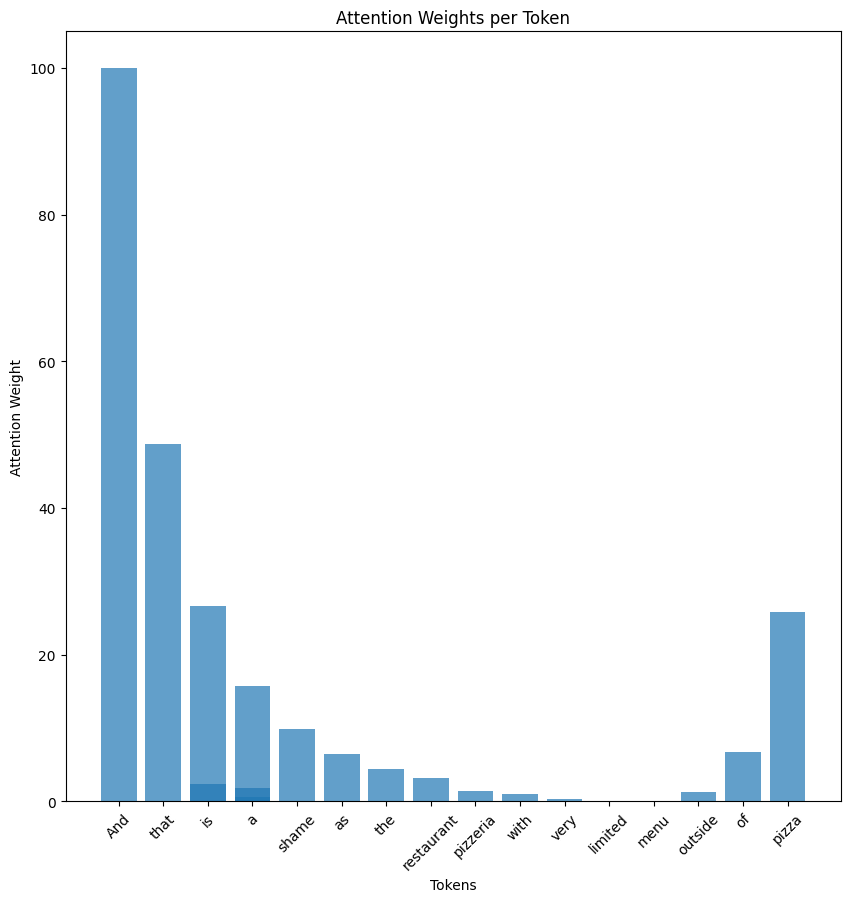

In [ ]:
input_text = "And that is a shame as the restaurant is a pizzeria with a very limited menu outside of pizza"
aspects = ["restaurant"]
analyze_sentiment(input_text, aspects)



Result for 'food': positive
Result for 'service': negative


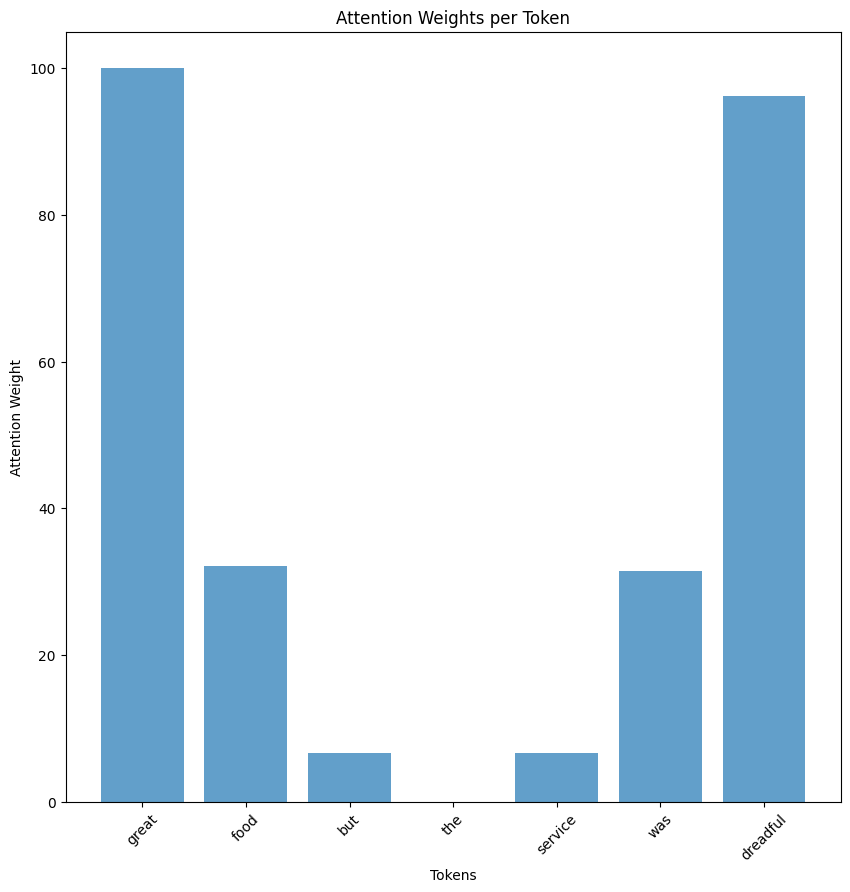

In [ ]:
input_text = "great food but the service was dreadful"
aspects = ["food", "service"]
analyze_sentiment(input_text, aspects)